In [1]:
import openfst_python as fst
from graph_utils.fsa import draw_fsa

### Операции над конечными автоматами

Далее будем рассматривать в качестве алфавита --- множество слов. И соответственно языки, распознаваемые автоматами, будут состоять из различных фраз.

**Конкатенация**

Конечные автоматы работают над строками, и некоторые строковые операции переносятся на автоматы:

In [2]:
symbols = fst.SymbolTable() # общая таблица символов для всех автоматов
eps = symbols.add_symbol("eps")

def arc(label, nextstate) :
    return fst.Arc(label, label, fst.Weight.One("tropical"), nextstate)

# построить автомат, распознающий ровно одно слово
def fsa(word):
    word_id = symbols.find(word) if symbols.member(word) else symbols.add_symbol(word)
    f = fst.Fst()
    start = f.add_state()
    end = f.add_state()
    f.set_start(start)
    f.set_final(end)
    f.add_arc(start, arc(word_id, end))
    f.set_input_symbols(symbols)
    return f

#обвноляем таблицу символов до последней актуальной -- необходимо для корректной работы алгоритмов
def actualize_symbols(*automates):
    for w in automates: 
        w.set_input_symbols(symbols) 

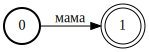

In [3]:
fsa("мама")

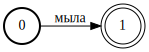

In [4]:
fsa("мыла")

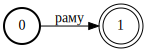

In [5]:
fsa("раму")

Конкатенируем

In [6]:
def concat(*automates):
    actualize_symbols(*automates)
    result = None
    for w in automates:
        if result:
            result.concat(w)
        else:
            result = w.copy()
    return result

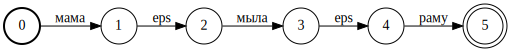

In [7]:
concat(fsa("мама"), fsa("мыла"), fsa("раму"))

При конкатенации автоматов, как и в случае строк, один автомат дописывается "в конец" другого.

**Теоретико-множественные операции**

Автоматы распознают языки -- множества строк. К языкам, как множествам, применимы операции пересечения, объединения, разности, дополнения. 

In [8]:
# объединение множеств

def union(*automates):
    actualize_symbols(*automates)
    
    result = None
    for w in automates:
        if result:
            result.union(w)
        else:
            result = w.copy()
    return result

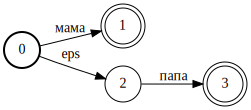

In [9]:
union(fsa("мама"), fsa("папа"))

Любое конечное множество фраз можно описать с помощью объединения и конкатенации автоматов для отдельных слов

Из-за особенностей реализации при применении конкатенации и объедиения в автомат добавляются \epsilon-переходы.
Далее мы их будем убирать с помощью `rmepsilon`

In [10]:
def to_fsa(phrase):
    return concat(*map(fsa, phrase.split())).rmepsilon()

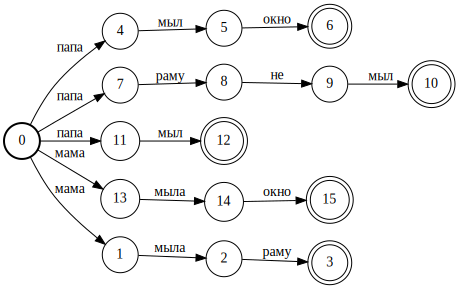

In [11]:
phrases = union(to_fsa("мама мыла раму"), 
                to_fsa("папа мыл окно"),
                to_fsa("папа раму не мыл"),
                to_fsa("папа мыл"),
                to_fsa("мама мыла окно")).rmepsilon()
phrases

Полученный автомат не является детерминированным. Если мы его детерминизируем, то получим [бор](https://neerc.ifmo.ru/wiki/index.php?title=Бор). 

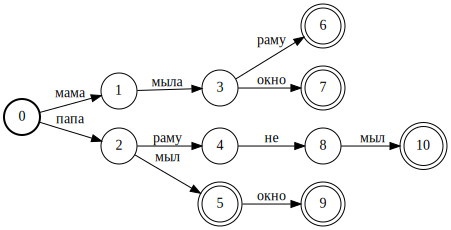

In [12]:
phrases_trie = fst.determinize(phrases)
phrases_trie

Бор удобен для реализации изменяемого множества строк, в котором нужно выполнять поиск.

N-граммные языковые модели строятся как некоторая модификация бора (помимо весов, нужны дополнительные переходы, называемые суффиксными ссылками; о них будет далее)

Объединение и конкатенация позволяют описать языки с конечным числом фраз.

Для построения бесконечных языков, над автоматами существует операция замыкания [замыкание Клини](https://ru.wikipedia.org/wiki/Звезда_Клини) --- автомат "зацикливается", что позволяет выразить повторяющиеся фрагменты.

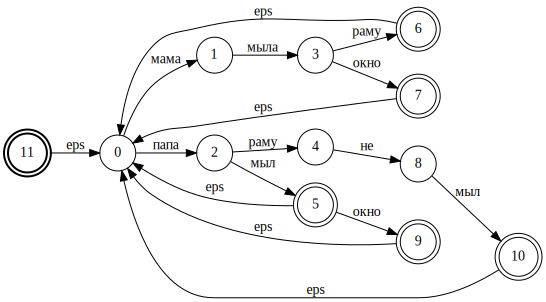

In [13]:
closed_trie = phrases_trie.closure()
closed_trie

Язык, описываемый полученным автоматом, в отличие от исходного, содержит, например фразу `мама мала раму папа мыл окно`. Также можно видеть, что этот автомат допускает пустую строку --- стартовое состояние (11) является одновременно и финальным.

Автомат недетерминирован, но если мы удалим $\epsilon$-переходы, он от этого странет куда менее наглядным

Замечательным фактом является то, что трех вышеописанных операций достаточно, чтоб для любого [регулярного языка](https://ru.wikipedia.org/wiki/Регулярный_язык) построить распознающий его автомат.

**Суффиксные ссылки и алгоритм Ахо-Корасик**

In [14]:
def make_trie(*phrases):
    return fst.determinize(union(*map(to_fsa, phrases)).rmepsilon())

In [15]:
#если строчка допустима, вернет автомат с этой строчкой. Иначе -- пустой результат
def accept(automata, phrase):
    return fst.compose(to_fsa(phrase), automata)

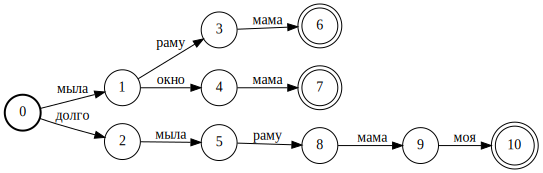

In [16]:
trie = make_trie("долго мыла раму мама моя", 
                 "мыла раму мама",
                 "мыла окно мама")
trie

Построенный автомат распознает язык, состоящий только из трех строк. Любые другие строки, даже содержащие данные, он отбросит. Но если провести его небольшую модификацию, этот автомат можно будет использовать для нахождения всех возможных вхождений этих строк в любую.


Если мы попытаемся натравить этот автомат на строку `долго мыла окно мама`, он ее отбросит. Но, если мы проведем из состояния 5 в состояние 1 $\epsilon$-переход, то эта строчка станет допустимой.

In [17]:
accept(trie, "долго мыла окно мама")

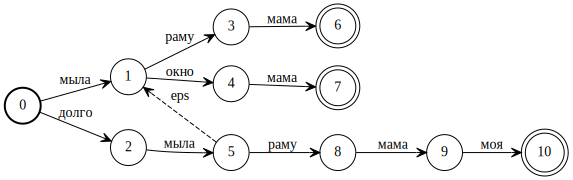

In [18]:
trie_temp = trie.copy()
trie_temp.add_arc(5, arc(eps, 1))
draw_fsa(trie_temp)

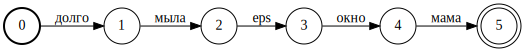

In [19]:
accept(trie_temp, "долго мыла окно мама")

Мы провели суффиксную ссылку. "Суффиксную" -- потому что строка "мыла" (состояние 1) является суффиксом строки "долго мыла" (состояние 5)

Будем говорить, что какая-то строка присутствуев в нашем боре, если есть вершина (любая), путь до которой и составляет эту строку.

Напримем, строка `долго мыла раму` в боре присутсвует, а `долго мыла окно` -- нет.

Если мы для каждогой строки, присутсвующей в боре, проведем суффиксную ссылку в какое-то другое состояние, соответсвующее ее наидлиннейшему суффиксу,
мы получим недетерминированный автомат, пригодный для решения задачи поиска подстрок.

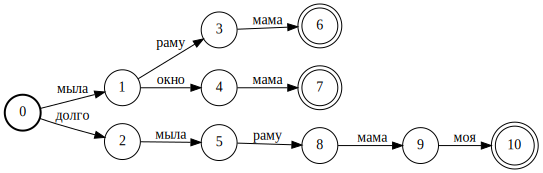

In [20]:
trie

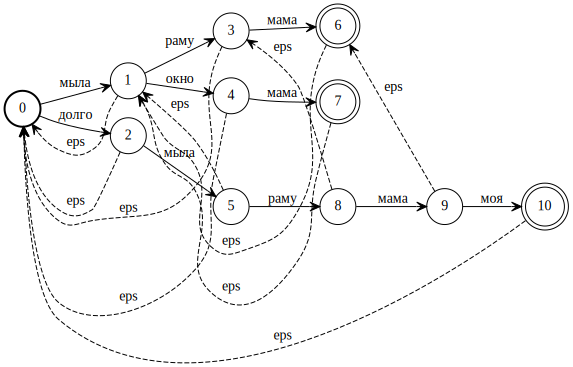

In [21]:
# проводим суффиксные ссылки:
trie_suff = trie.copy()
trie_suff.add_arc(1, arc(eps, 0)) # мыла -> ""
trie_suff.add_arc(2, arc(eps, 0)) # долго -> ""
trie_suff.add_arc(3, arc(eps, 0)) # мыла раму -> "" (строка "раму" не присутсвует)
trie_suff.add_arc(4, arc(eps, 0)) # мыла окно -> "" (строка "окно" не присутсвует)
trie_suff.add_arc(5, arc(eps, 1)) # долго мыла -> мыла
trie_suff.add_arc(6, arc(eps, 1)) # мыла раму мама -> "" (строк "мама" и "раму мама" нет)
trie_suff.add_arc(7, arc(eps, 1)) # мыла окно мама -> "" (строк "мама" и "окно мама" нет)
trie_suff.add_arc(8, arc(eps, 3)) # долго мыла раму -> мыла раму
trie_suff.add_arc(9, arc(eps, 6)) # долго мыла раму мама -> мыла раму мама
trie_suff.add_arc(10, arc(eps, 0)) # долго мыла раму мама моя -> ""
 
draw_fsa(trie_suff)

Почти все готово. Но этот автомат забракует строки, не начинающиеся с "мама" или "долго". Поэтому добавим в начальное состояние еще петли по каждому символу

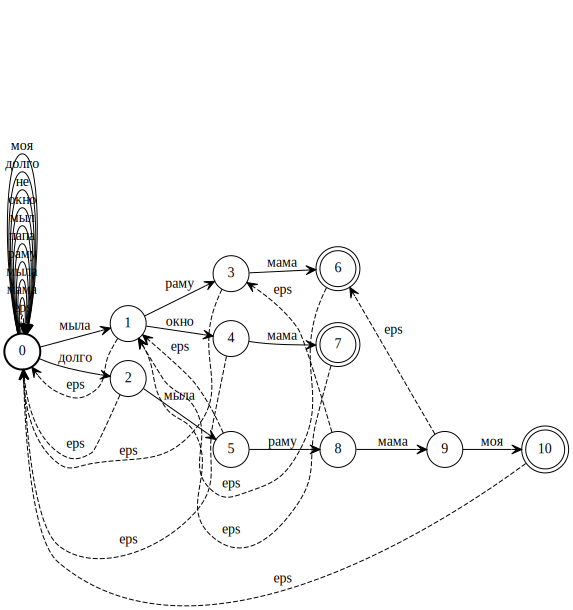

In [22]:
search_automata = trie_suff.copy()
for word_id, _ in symbols:
    search_automata.add_arc(0, arc(word_id, 0))
draw_fsa(search_automata)

Удаляем $\epsilon$-переходы, детерминизируем и получаем автомат, с помощью которого можно искать все вхождения подстрок в строку.

*Алгоритм: После каждого обработанного символа проверить, не находится ли автомат в конечном состоянии. Все.*

Собственно, возвращаясь к упомянутым $N$-граммным языковым моделям: автомат для $N$-граммной модели -- это бор, построенный по всем $1,2,3...N$-граммам + суффиксные ссылки.